In [307]:
#Importing libraries
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
import pandas as pd
from numpy import asarray
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import datetime
from statsmodels.tsa.tsatools import lagmat
from statsmodels.tsa.arima.model import ARIMA
from pandas import concat


# Data Import and Cleaning

In [308]:
%store -r df_cleaned
df = df_cleaned 

In [309]:
TS1 = df[(df['Plz'] == "['25', '24']")]
TS1_A2 = TS1[TS1['full'] == 'A2 -  geschreddert']
TS1_A1A2 = TS1[TS1['full'] == 'A1 & A2 -  geschreddert']
TS1_A2A3 = TS1[TS1['full'] == 'A2 & A3 -  geschreddert']

# Modelling - Train, test split

# Random Forest

In [310]:
# transform a time series dataset into a supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
 n_vars = 1 if type(data) is list else data.shape[1]
 df = pd.DataFrame(data)
 cols = list()
 # input sequence (t-n, ... t-1)
 for i in range(n_in, 0, -1):
    cols.append(df.shift(i))
 # forecast sequence (t, t+1, ... t+n)
 for i in range(0, n_out):
    cols.append(df.shift(-i))
    # put it all together
    agg = concat(cols, axis=1)
# drop rows with NaN values
 if dropnan:
    agg.dropna(inplace=True)
 return agg.values

In [311]:
X = TS1_A1A2["wPreis"].values.reshape(-1, 1)


In [312]:
rf_data = series_to_supervised(X, n_in=4)

In [313]:

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
 return data[:-n_test, :], data[-n_test:, :]

### Walk-forward validation

In [314]:
from sklearn.ensemble import RandomForestRegressor

In [315]:
# walk-forward validation for univariate data
def rf_walk_forward_validation(data, n_test):
 predictions = list()
 direction_accuracies = list() 
 # split dataset
 train, test = train_test_split(data, n_test)
 # seed history with training dataset
 history = [x for x in train]
 # step over each time-step in the test set
 for i in range(len(test)):
    # split test row into input and output columns
    testX, testy = test[i, :-1], test[i, -1]
    # fit model on history and make a prediction
    yhat = random_forest_forecast(history, testX)
    # store forecast in list of predictions
    predictions.append(yhat)
    if i > 0:  # Direction accuracy is not applicable for the first prediction
            forecast_diff = yhat - predictions[-2]
            actual_diff = testy - test[i - 1, -1]
            direction_accuracy = int(np.sign(forecast_diff) == np.sign(actual_diff))
            direction_accuracies.append(direction_accuracy)
    # add actual observation to history for the next loop
    history.append(test[i])
    # summarize progress
    # print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
 # estimate prediction error
 mae = mean_absolute_error(test[:, -1], predictions)
 me = np.mean(predictions - test[:, -1])  # Mean Error
 rmse = mean_squared_error(test[:, -1], predictions, squared=False)
 overall_direction_accuracy = np.mean(direction_accuracies)

 # return mae, me, rmse ,test[:, -1], predictions, overall_direction_accuracy 
 return {'mae':mae, 'me': me, 'rmse': rmse, 'expected':test[:, -1], 'predictions': predictions, 'direction_accuracy': overall_direction_accuracy}

In [316]:
# fit an random forest model and make a one step prediction
def random_forest_forecast(train, testX):
 # transform list into array
 train = asarray(train)
 # split into input and output columns
 trainX, trainy = train[:, :-1], train[:, -1]
 # fit model
 model = RandomForestRegressor(n_estimators=1000, random_state=42)
 model.fit(trainX, trainy)
 # make a one-step prediction
 yhat = model.predict([testX])
 return yhat[0]

In [317]:
splitratio = 0.05
nobs = round(len(TS1_A1A2)*splitratio)

MAE: 7.234
ME: 2.526
RMSE: 8.733
Direction Accuracy: 0.500


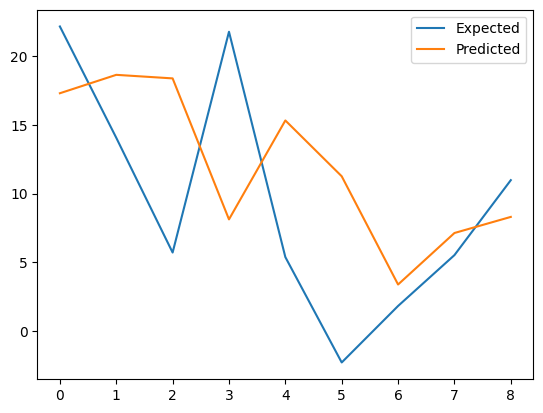

In [318]:
# evaluate
wf_accuracy_prod = rf_walk_forward_validation(rf_data, nobs)
mae = wf_accuracy_prod['mae']
me = wf_accuracy_prod['me']
rmse = wf_accuracy_prod['rmse']
expected = wf_accuracy_prod['expected']
predictions = wf_accuracy_prod['predictions']
direction_accuracy = wf_accuracy_prod['direction_accuracy']

print('MAE: %.3f' % mae)
print('ME: %.3f' % me)
print('RMSE: %.3f' % rmse)
print('Direction Accuracy: %.3f' % direction_accuracy)
# plot expected vs preducted
plt.plot(expected, label='Expected')
plt.plot(predictions, label='Predicted')
plt.legend()
plt.show()

In [319]:
results = {
    'mae': [mae],
    'me': [me],
    'rmse': [rmse],
    'direction_accuracy': [direction_accuracy]
}

# Convert the dictionary into a DataFrame
RandomForest_wf = pd.DataFrame(results)
RandomForest_wf

,mae,me,rmse,direction_accuracy
0,7.234147,2.525658,8.732761,0.5


In [320]:
%store RandomForest_wf

Stored 'RandomForest_wf' (DataFrame)


### Rolling forecast for Random Forest  

Since this method uses 4 lagged values as input for predicting the next step, we are exposing the test data set in every iteration. So essentially this is a forecast with a window of "input" moving along the test set, predicting one step at a time, but having been trained on the original training set only once.

In [321]:
train, test = train_test_split(rf_data, nobs)


In [322]:
test

array([[14.94494128, 13.7571362 , 17.34321268, 19.08385688, 22.15590367],
       [13.7571362 , 17.34321268, 19.08385688, 22.15590367, 14.05657364],
       [17.34321268, 19.08385688, 22.15590367, 14.05657364,  5.70419682],
       [19.08385688, 22.15590367, 14.05657364,  5.70419682, 21.77178067],
       [22.15590367, 14.05657364,  5.70419682, 21.77178067,  5.37221127],
       [14.05657364,  5.70419682, 21.77178067,  5.37221127, -2.29737704],
       [ 5.70419682, 21.77178067,  5.37221127, -2.29737704,  1.8152799 ],
       [21.77178067,  5.37221127, -2.29737704,  1.8152799 ,  5.51596431],
       [ 5.37221127, -2.29737704,  1.8152799 ,  5.51596431, 10.97189655]])

In [323]:
train = asarray(train)

In [324]:
trainX, trainy = train[:, :-1], train[:, -1]


In [325]:
model_rf_rolling = RandomForestRegressor(n_estimators=1000, random_state=42)
model_rf_rolling.fit(trainX, trainy)

RandomForestRegressor(n_estimators=1000, random_state=42)

In [326]:
predictions = list()
direction_accuracies = list() 

In [327]:
for i in range(len(test)):
    # split test row into input and output columns
    testX, testy = test[i, :-1], test[i, -1]
    # ONLY MAKE ONE-STEP PREDICTIONS BASED ON MODEL TRAINED ONCE 
    print(testX)
    yhat = model_rf_rolling.predict([testX])
    # store forecast in list of predictions
    predictions.append(yhat)
    if i > 0:  # Direction accuracy is not applicable for the first prediction
            forecast_diff = yhat - predictions[-2]
            actual_diff = testy - test[i - 1, -1]
            direction_accuracy = int(np.sign(forecast_diff) == np.sign(actual_diff))
            direction_accuracies.append(direction_accuracy)
    # summarize progress
    print('>expected=%.1f, predicted=%.1f' % (testy, yhat))


[14.94494128 13.7571362  17.34321268 19.08385688]
>expected=22.2, predicted=17.3
[13.7571362  17.34321268 19.08385688 22.15590367]
>expected=14.1, predicted=18.3
[17.34321268 19.08385688 22.15590367 14.05657364]
>expected=5.7, predicted=18.9
[19.08385688 22.15590367 14.05657364  5.70419682]
>expected=21.8, predicted=8.3
[22.15590367 14.05657364  5.70419682 21.77178067]
>expected=5.4, predicted=16.8
[14.05657364  5.70419682 21.77178067  5.37221127]
>expected=-2.3, predicted=9.0
[ 5.70419682 21.77178067  5.37221127 -2.29737704]
>expected=1.8, predicted=2.4
[21.77178067  5.37221127 -2.29737704  1.8152799 ]
>expected=5.5, predicted=6.4
[ 5.37221127 -2.29737704  1.8152799   5.51596431]
>expected=11.0, predicted=8.8


In [328]:
testy

10.97189655172414

In [305]:
predictions

[17.29697807420951,
 18.63626821607284,
 18.377366982924134,
 8.117158808149979,
 15.316794688846697,
 11.253767254418669,
 3.37648139803218,
 7.125296168675986,
 8.297243262581537]

In [ ]:
mae = mean_absolute_error(test[:, -1], predictions)
me = np.mean(predictions - test[:, -1])  # Mean Error
rmse = mean_squared_error(test[:, -1], predictions, squared=False)
overall_direction_accuracy = np.mean(direction_accuracies)

#return error, me, rmse ,test[:, -1], predictions, overall_direction_accuracy 

Forecast accuracy for Rolling Forecast with Random Forest
MAE: 6.894
ME: 2.346
RMSE: 8.555
Direction Accuracy: 0.375


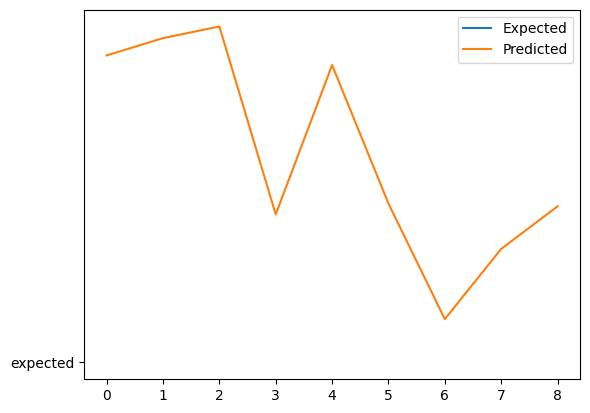

In [ ]:
#print('MAE: %.3f' % mae)
print('Forecast accuracy for Rolling Forecast with Random Forest')
print('MAE: %.3f' % mae)
print('ME: %.3f' % me)
print('RMSE: %.3f' % rmse)
print('Direction Accuracy: %.3f' % overall_direction_accuracy)
# plot expected vs preducted
plt.plot(test[:, -1], label='Expected')
plt.plot(predictions, label='Predicted')
plt.legend()
plt.show()

In [ ]:
roll_results = {
    'mae': [mae],
    'me': [me],
    'rmse': [rmse],
    'direction_accuracy': [overall_direction_accuracy]
}

# Convert the dictionary into a DataFrame
RandomForest_roll = pd.DataFrame(roll_results)
RandomForest_roll

,mae,me,rmse,direction_accuracy
0,6.893966,2.345931,8.555033,0.375


In [ ]:
%store RandomForest_roll


Stored 'RandomForest_roll' (DataFrame)


## Static (Multi-step) Forecast

Since the above methods use the 4-week lagged values as inputs, it is not possible to use the same method to do static (multi-step) forecasting. For this, we will need to train the model on the original training dataset, not expose it to the test data set and ask it to predict for 6 steps ahead. 

This can be achieved using the ForecasterAutoreg class from the SKforecast package. This class turns any regressor compatible with the scikit-learn API into a
recursive autoregressive (multi-step) forecaster.

In [ ]:
from skforecast.ForecasterAutoreg import ForecasterAutoreg

In [ ]:
forecaster_rf = ForecasterAutoreg(
                    regressor = RandomForestRegressor(random_state=963),
                    lags      = 4
                )

In [ ]:
splitratio = 0.05
nobs = round(len(TS1_A1A2)*splitratio)
df_train, df_test = TS1_A1A2[0:-nobs], TS1_A1A2[-nobs:]

In [ ]:
y_train = df_train['wPreis']

In [ ]:
# Now you can pass y_train to forecaster.fit()
forecaster_rf.fit(y=y_train)

In [ ]:
predicted_test = forecaster_rf.predict(steps = len(df_test))

In [ ]:
def forecast_accuracy(forecast, actual):
      mae = mean_absolute_error(actual, forecast)
      me = np.mean(forecast - actual)             # ME
      rmse = np.mean((forecast - actual)**2)**.5  # RMSE
      # Direction accuracy
      forecast_diff = np.diff(forecast)
      actual_diff = np.diff(actual)
      direction_accuracy = np.mean(np.sign(forecast_diff) == np.sign(actual_diff))
    
      return {'mae': mae, 'me': me, 'rmse': rmse, 'direction_accuracy': direction_accuracy}


In [ ]:
predicted_test.index = df_test.index


In [ ]:
def adjust(val, length= 6): return str(val).ljust(length) # length
print('Random Forest Static Forecast Accuracy of: wPreis')
stat_accuracy_prod = forecast_accuracy(predicted_test, df_test['wPreis'])
for k, v in stat_accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))




Random Forest Static Forecast Accuracy of: wPreis
mae    :  9.5435
me     :  6.9356
rmse   :  10.8143
direction_accuracy :  0.375


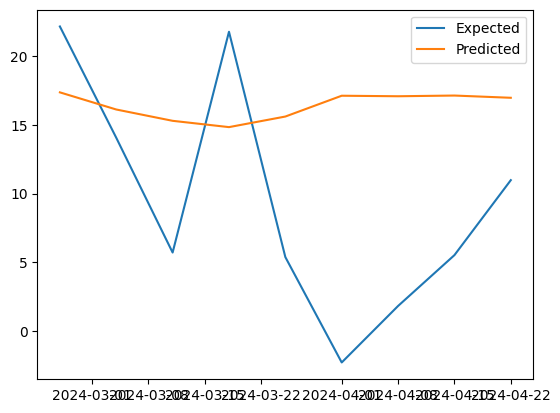

In [ ]:
# plot expected vs preducted
plt.plot(df_test['wPreis'], label='Expected')
plt.plot(predicted_test, label='Predicted')
plt.legend()
plt.show()

In [ ]:
RandomForest_static = pd.DataFrame([stat_accuracy_prod])
RandomForest_static



,mae,me,rmse,direction_accuracy
0,9.543498,6.935595,10.814334,0.375


In [ ]:
%store RandomForest_static

Stored 'RandomForest_static' (DataFrame)


## All other clusters and categories 

In [ ]:
def static_forecast(data):
    category = data['full'].unique()
    cluster = data['Plz'].unique()
    splitratio = 0.05
    nobs = round(len(data)*splitratio)

    df_train, df_test = data[0:-nobs], data[-nobs:]


    forecaster_rf = ForecasterAutoreg(
                    regressor = RandomForestRegressor(random_state=963),
                    lags      = 4
                )

    y_train = df_train['wPreis']
    forecaster_rf.fit(y=y_train)
    predicted_test = forecaster_rf.predict(steps = len(df_test))
    predicted_test.index = df_test.index
    
    return forecast_accuracy(predicted_test, df_test['wPreis'])

In [ ]:
def rolling_forecast(data):
    category = data['full'].unique()
    cluster = data['Plz'].unique()
    splitratio = 0.05
    nobs = round(len(data)*splitratio)

    X = data["wPreis"].values.reshape(-1, 1)

    rf_data = series_to_supervised(X, n_in=4)


    train, test = train_test_split(rf_data, nobs)
    train = asarray(train)
    trainX, trainy = train[:, :-1], train[:, -1]


    model_rf_rolling = RandomForestRegressor(n_estimators=1000, random_state=42)
    model_rf_rolling.fit(trainX, trainy)

    predictions = list()
    direction_accuracies = list()   

    for i in range(len(test)):
        # split test row into input and output columns
        testX, testy = test[i, :-1], test[i, -1]
        # ONLY MAKE ONE-STEP PREDICTIONS BASED ON MODEL TRAINED ONCE 
        # print(testX)
        yhat = model_rf_rolling.predict([testX])
        # store forecast in list of predictions
        predictions.append(yhat)
        if i > 0:  # Direction accuracy is not applicable for the first prediction
                forecast_diff = yhat - predictions[-2]
                actual_diff = testy - test[i - 1, -1]
                direction_accuracy = int(np.sign(forecast_diff) == np.sign(actual_diff))
                direction_accuracies.append(direction_accuracy)
    

    mae = mean_absolute_error(test[:, -1], predictions)
    me = np.mean(predictions - test[:, -1])  # Mean Error
    rmse = mean_squared_error(test[:, -1], predictions, squared=False)
    overall_direction_accuracy = np.mean(direction_accuracies)

    return {'mae': mae, 'me': me, 'rmse': rmse, 'direction_accuracy': overall_direction_accuracy}

In [ ]:
def wf_forecast(data):
    category = data['full'].unique()
    cluster = data['Plz'].unique()
    splitratio = 0.05
    nobs = round(len(data)*splitratio)

    X = data["wPreis"].values.reshape(-1, 1)

    dt_data = series_to_supervised(X, n_in=4)

    # print(f'Decision Tree Walk-forward forecast Accuracy of: wPreis in {cluster} for {category}')
    wf_accuracy_prod = rf_walk_forward_validation(dt_data, nobs)
    # mae, me, rmse, y, yhat, direction_accuracy = 
    return wf_accuracy_prod



In [ ]:
clusters = df['Plz'].unique() 
datasets = []
for cluster in clusters:
    ds = df[(df['Plz'] == cluster)]
    categories = ds['full'].unique()
    for category in categories:
        datasets.append(ds[ds['full'] == category])

In [ ]:
import warnings

# Filter out the specific warning
warnings.filterwarnings('ignore')

In [ ]:
data = []
# Loop through each category
for dataset in datasets:
    static_forecast(dataset)
    rolling_forecast(dataset)
    wf_forecast(dataset)
    static_results = static_forecast(dataset)
    rolling_results = rolling_forecast(dataset)
    wf_results = wf_forecast(dataset)
    
    # Create a dictionary to store the results
    results_dict = {
        'Cluster': dataset['Plz'].iloc[0],   
        'Category': dataset['full'].iloc[0],   
        'RandomForest_static_mae': static_results['mae'],
        'RandomForest_static_me': static_results['me'],
        'RandomForest_static_rmse': static_results['rmse'],
        'RandomForest_static_direction_accuracy': static_results['direction_accuracy'],
        'RandomForest_rolling_mae': rolling_results['mae'],
        'RandomForest_rolling_me': rolling_results['me'],
        'RandomForest_rolling_rmse': rolling_results['rmse'],
        'RandomForest_rolling_direction_accuracy': rolling_results['direction_accuracy'],
        'RandomForest_wf_mae': wf_results['mae'],
        'RandomForest_wf_me': wf_results['me'],
        'RandomForest_wf_rmse': wf_results['rmse'],
        'RandomForest_wf_direction_accuracy': wf_results['direction_accuracy']
    }
    
    # Append the dictionary to the list
    data.append(results_dict)

# Create a DataFrame from the list of dictionaries
df_results = pd.DataFrame(data)

# Print the DataFrame
df_results


,Cluster,Category,RandomForest_static_mae,RandomForest_static_me,RandomForest_static_rmse,RandomForest_static_direction_accuracy,RandomForest_rolling_mae,RandomForest_rolling_me,RandomForest_rolling_rmse,RandomForest_rolling_direction_accuracy,RandomForest_wf_mae,RandomForest_wf_me,RandomForest_wf_rmse,RandomForest_wf_direction_accuracy
0,"['25', '24']",A2 - geschreddert,10.905132,9.200580,12.466998,0.000000,6.758716,3.552916,7.735114,0.500000,6.883025,3.560050,8.110749,0.375000
1,"['25', '24']",A1 & A2 - geschreddert,9.543498,6.935595,10.814334,0.375000,6.893966,2.345931,8.555033,0.375000,7.234147,2.525658,8.732761,0.500000
2,"['25', '24']",A2 & A3 - geschreddert,13.021664,11.800387,14.869992,0.125000,6.407393,4.994287,8.434553,0.250000,6.882823,4.544905,8.503080,0.250000
3,"['80', '81', '82', '83', '84', '85', '93', '94']",A3 - geschreddert,5.439034,-5.439034,5.914251,0.375000,2.553899,-2.094583,2.742342,0.625000,2.153563,-1.561139,2.400753,0.500000
4,"['80', '81', '82', '83', '84', '85', '93', '94']",A1 & A2 - geschreddert,4.816681,4.719118,7.072996,0.285714,2.454077,2.060142,5.114434,0.571429,2.422504,1.785901,5.024926,0.571429
5,"['80', '81', '82', '83', '84', '85', '93', '94']",A2 & A3 - geschreddert,4.669861,-4.531848,5.293486,0.375000,3.211788,-2.102068,3.458940,0.375000,2.675646,-0.970846,2.989345,0.500000
6,"['70', '71', '73', '74', '75', '76']",A2 & A3 - geschreddert,5.059856,-0.430358,5.604431,0.428571,5.604946,-0.352185,5.877890,0.714286,5.327165,-0.315258,5.642023,0.714286
7,"['50', '51', '52', '53']",A2 & A3 - geschreddert,2.421096,-1.841129,2.929957,0.500000,2.647924,-1.085063,3.131479,0.250000,2.600787,-0.222000,2.914120,0.500000
8,"['50', '51', '52', '53']",A3 - geschreddert,2.569158,-0.942903,2.730899,0.750000,2.944003,0.370864,3.351052,0.500000,3.097787,0.507629,3.567518,0.625000
9,"['40', '41', '42', '44', '45', '46', '47']",A2 & A3 - ungeschreddert,2.108932,0.974045,2.335458,0.500000,1.833089,0.594517,2.070963,0.375000,1.591850,0.668129,1.802207,0.375000


In [ ]:
df_metrics = df_results[['Cluster', 'Category', 'RandomForest_static_rmse', 'RandomForest_rolling_rmse',  'RandomForest_wf_rmse', 'RandomForest_static_direction_accuracy', 'RandomForest_rolling_direction_accuracy', 'RandomForest_wf_direction_accuracy']]

In [ ]:
def getRMSEplot(df_plot):
    traces = []
    for metric in ['RandomForest_static_rmse', 'RandomForest_rolling_rmse',  'RandomForest_wf_rmse']:
        trace = go.Bar(
            x= df_plot[metric],
            y= df_plot['Cluster'], 
            name=metric,
            orientation='h'
        )
        traces.append(trace)

    # Define layout
    layout = go.Layout(
        title= f'Comparison of RandomForest RMSE for Static, Rolling and Walk-forward Validation across Clusters for {df_plot["Category"].iloc[0]}',
        xaxis=dict(title='RMSE'),
        yaxis=dict(title='Cluster'),
        barmode='group'
    )

    # Create figure
    fig = go.Figure(data=traces, layout=layout)

    # Show figure
    fig.show()


In [ ]:
def getDirAccplot(df_plot):
    traces = []
    for metric in ['RandomForest_static_direction_accuracy', 'RandomForest_rolling_direction_accuracy', 'RandomForest_wf_direction_accuracy']:
        trace = go.Bar(
            x= df_plot[metric],
            y= df_plot['Cluster'], 
            name=metric,
            orientation='h'
        )
        traces.append(trace)

    # Define layout
    layout = go.Layout(
        title= f'Comparison of Direction Accuracy using RandomForest between Static, Rolling and Walk-Forward across Clusters for {df_plot["Category"].iloc[0]}',
        xaxis=dict(title='Direction Accuracy'),
        yaxis=dict(title='Cluster'),
        barmode='group'
    )

    # Create figure
    fig = go.Figure(data=traces, layout=layout)

    # Show figure
    fig.show()


In [ ]:
for category in df_metrics['Category'].unique():
    filtered = df_metrics[df_metrics['Category'] == category]
    getRMSEplot(filtered)
    getDirAccplot(filtered)